# Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/sustainlab-group/sustainbench.git /content/drive/MyDrive/sustainbench

Mounted at /content/drive
fatal: destination path '/content/drive/MyDrive/sustainbench' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/sustainbench

!pip install -q condacolab
import condacolab
condacolab.install()

# Create the Conda environment from the .yml file
!conda env create -f /content/drive/MyDrive/sustainbench/env_bench.yml

/content/drive/MyDrive/sustainbench
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...
Channels:
 - pytorch
 - nvidia
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.11.3

Please update conda by running

    $ conda update -n base -c conda-forge conda



pytorch-1.9.1        | 1.44 GB   | :   0% 0/1 [00:00<?, ?it/s]
cudatoolkit-11.1.74  | 1.19 GB   | :   0% 0/1 [00:00<?, ?it/s]

mkl-2022.1.0         | 129.7 MB  | :   0% 0/1 [00:00<?, ?it/s]


scipy-1.7.3          | 22.0 MB   | :   0% 0/1 [00:00<?, ?it/s]



python-3.9.15        | 20.9 MB   | :   0% 0/1 [00:00<?, ?it/s]




pandoc-3.6.1         | 20.3 MB   | :   0% 0/1 [00:00<?, ?it/s]





pandas-1.3.5         | 1

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from datetime import datetime
import math
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.layers import Dense, LSTM
import itertools

# 1. LSTM Baseline Model

## Build the lstm model

This LSTM_NeuralModel references from the oringial paper's github:  https://github.com/AnnaXWang/deep-transfer-learning-crop-prediction/blob/master/code/nnet_LSTM.py.

And modified some codes to meet the updated Implementation reuqirement for TensorFlow 2.x.

In [ ]:

class LSTM_Config():
    B, W, C = 32,32,9
    H = 32 #all season lengths will be 32
    loss_lambda = 0.75
    lstm_layers = 1
    lstm_H = 200
    dense = 356
    season_len = 32

    train_step = 10000000
    lr = 0.005
    #keep probability
    drop_out = 0.75

    def __init__(self, season_frac=None):
        if season_frac is not None:
            self.H = int(season_frac*self.H)

def dense(input_data, H, N=None, name = "dense"):
    if not N:
        N = input_data.get_shape()[-1]
    with tf.variable_scope(name):
        W = tf.get_variable("W", [N, H], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b", [1, H])
        tf.summary.histogram(name + ".W", W)
        tf.summary.histogram(name + ".b", b)
        return tf.matmul(input_data, W, name="matmul") + b

def lstm_net(input_data,output_data,config,keep_prob = 1,name="lstm_net"):
    with tf.variable_scope(name):
        lstm_cell = tf.nn.rnn_cell.LSTMCell(config.lstm_H,state_is_tuple=True)
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.lstm_layers,state_is_tuple=True)
        state = cell.zero_state(config.B, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, input_data,
                       initial_state=state, time_major=True)
        tf.summary.histogram(name + '.outputs', outputs)
        output_final = tf.squeeze(tf.slice(outputs, [config.H-1,0,0] , [1,-1,-1]))
        tf.summary.histogram(name + '.output_final', output_final)
        fc1 = dense(output_final, config.dense, name="dense")

        logit = tf.squeeze(dense(fc1,1,name='logit'))
        tf.summary.histogram(name + '.logit', logit)
        loss_err = tf.nn.l2_loss(logit - output_data)
        loss_reg = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        total_loss = config.loss_lambda * loss_err + (1 - config.loss_lambda) * loss_reg

        tf.summary.scalar(name + '.loss_err', loss_err)
        tf.summary.scalar(name + '.loss_reg', loss_reg)
        tf.summary.scalar(name + '.loss_total', total_loss)

        return logit,total_loss,fc1

class LSTM_NeuralModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_Model"):
        super(LSTM_NeuralModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        x = tf.transpose(inputs, perm=[2, 0, 1, 3])
        x = tf.reshape(x, [-1, self.config.W, self.config.H * self.config.C])

        # LSTM layer
        x = self.lstm(x, training=training)

        # Dense layer
        x = self.dense1(x)
        output = self.logit(x)

        return output




In [ ]:
%cd /content/drive/MyDrive/sustainbench

from sustainbench import get_dataset
from sustainbench.common.data_loaders import get_train_loader
from sustainbench.common.data_loaders import get_eval_loader

dataset = get_dataset(dataset='crop_yield', download=False, split_scheme='argentina') # argentina soybean


/content/drive/MyDrive/sustainbench


In [ ]:

def train_model(model, dataset, config, num_epochs=20):

    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)

    train_data = dataset.get_subset('train')
    train_loader = get_train_loader('standard', train_data, batch_size=32)

    model = LSTM_NeuralModel(config)
    r2list = []
    rmselist = []

    for epoch in range(num_epochs):
    # Iterate through the train_loader to access batches of data
        y_true = []
        y_pred = []
        batch_size = config.B
        for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                loss = loss_fn(batch_y, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            y_true.extend(batch_y.numpy().flatten())
            y_pred.extend(predictions.numpy().flatten())
            print(f'Epoch {epoch +1}, Batch {batch_idx +1}, Loss: {loss.numpy()}')

        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2list.append(r2)
        rmselist.append(rmse)
    return model, r2list, rmselist




In [ ]:
def eval_model(model, dataset, config, num_epochs=20):
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)

    eval_data = dataset.get_subset('val')
    eval_loader = get_eval_loader('standard', eval_data, batch_size=32)

    r2list_eval = []
    rmselist_eval = []

    for epoch in range(num_epochs):

        y_true_eval = []
        y_pred_eval = []
        for batch_idx, (batch_x, batch_y) in enumerate(eval_loader):
            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                loss = loss_fn(batch_y, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            y_true_eval.extend(batch_y.numpy().flatten())
            y_pred_eval.extend(predictions.numpy().flatten())
            print(f'Epoch {epoch +1}, Batch {batch_idx +1}, Loss: {loss.numpy()}')

        r2_eval = r2_score(y_true_eval, y_pred_eval)
        rmse_eval = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))
        r2list_eval.append(r2_eval)
        rmselist_eval.append(rmse_eval)
    return r2list_eval, rmselist_eval



In [ ]:
def plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval):
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    # Plot R2
    axes[0].plot(r2list, label='R²_train', color='purple', marker='o')
    axes[0].plot(r2list_eval, label='R²_eval', color='skyblue', marker='x')
    axes[0].set_title('R² Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('R²')
    axes[0].grid(True)
    axes[0].legend()

    # Plot RMSE
    axes[1].plot(rmselist, label='RMSE_train', color='green', marker='o')
    axes[1].plot(rmselist_eval, label='RMSE_eval', color='skyblue', marker='x')
    axes[1].set_title('RMSE Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('RMSE')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Epoch 1, Batch 1, Loss: 7.3430867195129395
Epoch 1, Batch 2, Loss: 1.3811581134796143
Epoch 1, Batch 3, Loss: 60.29442596435547
Epoch 1, Batch 4, Loss: 4.219316482543945
Epoch 1, Batch 5, Loss: 1.5368239879608154
Epoch 1, Batch 6, Loss: 4.668774604797363
Epoch 1, Batch 7, Loss: 4.159651756286621
Epoch 1, Batch 8, Loss: 3.006847858428955
Epoch 1, Batch 9, Loss: 1.8169076442718506
Epoch 1, Batch 10, Loss: 0.8902307152748108
Epoch 1, Batch 11, Loss: 0.9379574060440063
Epoch 1, Batch 12, Loss: 1.9370532035827637
Epoch 1, Batch 13, Loss: 1.578277349472046
Epoch 1, Batch 14, Loss: 0.6582778692245483
Epoch 1, Batch 15, Loss: 0.6974326372146606
Epoch 1, Batch 16, Loss: 0.7991141080856323
Epoch 1, Batch 17, Loss: 1.2277628183364868
Epoch 1, Batch 18, Loss: 1.0058987140655518
Epoch 1, Batch 19, Loss: 0.9372795224189758
Epoch 1, Batch 20, Loss: 0.9927935600280762
Epoch 1, Batch 21, Loss: 0.7937749624252319
Epoch 1, Batch 22, Loss: 0.5699092149734497
Epoch 1, Batch 23, Loss: 0.6529210805892944
Epo

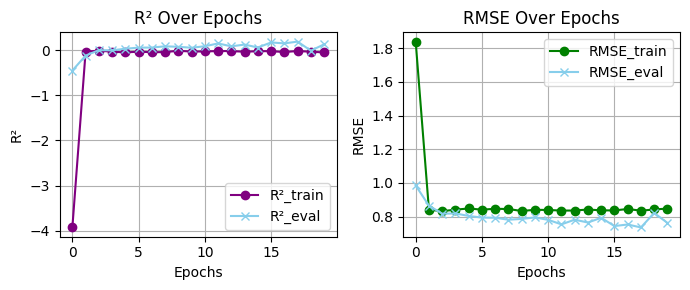

In [ ]:
# train and eval the model

model, r2list, rmselist = train_model(LSTM_NeuralModel, dataset, LSTM_Config(), 20)
r2list_eval, rmselist_eval = eval_model(model, dataset, LSTM_Config())
plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)


In [ ]:
# baseline lstm model result

def test_model(model, dataset, config):
    test_data = dataset.get_subset('test')
    test_loader = get_eval_loader('standard', test_data, batch_size=config.B)

    y_true = []
    y_pred = []

    for batch in test_loader:
        x_batch, y_batch = batch
        predictions = model(x_batch, training=False)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(predictions.numpy().flatten())
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

r2, rmse = test_model(model, dataset, LSTM_Config())
print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')



R²: -0.3901
RMSE: 0.9173


## Fine-tunning the lstm model

In [ ]:
# update the __init__ to update the hyper-parameters

class LSTM_Config():
    B, W, C = 32,32,9
    H = 32 #all season lengths will be 32
    loss_lambda = 0.75
    lstm_layers = 1
    lstm_H = 200
    dense = 356
    season_len = 32

    train_step = 10000000
    lr = 0.005
    #keep probability
    drop_out = 0.75

    # update the hyper-parameters for grid-search
    def __init__(self, season_frac=None, lstm_H=None, drop_out=None, lr=None): # update
        if season_frac is not None:
            self.H = int(season_frac *self.H)
        if lstm_H is not None:
            self.lstm_H = lstm_H
        if drop_out is not None:
            self.drop_out = drop_out
        if lr is not None:
            self.lr = lr

def dense(input_data, H, N=None, name = "dense"):
    if not N:
        N = input_data.get_shape()[-1]
    with tf.variable_scope(name):
        W = tf.get_variable("W", [N, H], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b", [1, H])
        tf.summary.histogram(name + ".W", W)
        tf.summary.histogram(name + ".b", b)
        return tf.matmul(input_data, W, name="matmul") + b

def lstm_net(input_data,output_data,config,keep_prob = 1,name="lstm_net"):
    with tf.variable_scope(name):
        lstm_cell = tf.nn.rnn_cell.LSTMCell(config.lstm_H,state_is_tuple=True)
        lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.lstm_layers,state_is_tuple=True)
        state = cell.zero_state(config.B, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, input_data,
                       initial_state=state, time_major=True)
        tf.summary.histogram(name + '.outputs', outputs)
        output_final = tf.squeeze(tf.slice(outputs, [config.H-1,0,0] , [1,-1,-1]))
        tf.summary.histogram(name + '.output_final', output_final)
        fc1 = dense(output_final, config.dense, name="dense")

        logit = tf.squeeze(dense(fc1,1,name='logit'))
        tf.summary.histogram(name + '.logit', logit)
        loss_err = tf.nn.l2_loss(logit - output_data)
        loss_reg = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        total_loss = config.loss_lambda * loss_err + (1 - config.loss_lambda) * loss_reg

        tf.summary.scalar(name + '.loss_err', loss_err)
        tf.summary.scalar(name + '.loss_reg', loss_reg)
        tf.summary.scalar(name + '.loss_total', total_loss)

        return logit,total_loss,fc1

class LSTM_NeuralModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_Model"):
        super(LSTM_NeuralModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        x = tf.transpose(inputs, perm=[2, 0, 1, 3])
        x = tf.reshape(x, [-1, self.config.W, self.config.H * self.config.C])

        # LSTM layer
        x = self.lstm(x, training=training)

        # Dense layer
        x = self.dense1(x)
        output = self.logit(x)

        return output



In [ ]:
drop_outs = [0.5, 0.75]
learning_rates = [0.1, 0.01, 0.005]
lstm_units = [200, 300]

param_grid = list(itertools.product(drop_outs, learning_rates, lstm_units))

best_rmse = 100
best_params = None

for drop_out, lr, lstm_H in param_grid:
    print(f'Training with dropout={drop_out}, lr={lr}, lstm_H={lstm_H}')
    config = LSTM_Config(lstm_H=lstm_H, drop_out=drop_out, lr=lr)
    model = LSTM_NeuralModel(config)

    trained_model,_,_ = train_model(model,dataset, config, num_epochs=15) #epochs to 15 according to the val pattern
    r2_value, rmse_value = test_model(trained_model, dataset, config)

    # Check if this combination gives a better RMSE
    if rmse_value < best_rmse:
        best_rmse = rmse_value
        best_params = (drop_out, lr, lstm_H)

    print(f'RMSE for this set: {rmse_value}')

print('\nBest parameters:')
print(f'Drop out rate: {best_params[0]}')
print(f'Learning rate: {best_params[1]}')
print(f'LSTM units: {best_params[2]}')
print(f'Best RMSE: {best_rmse}')

Streaming output truncated to the last 5000 lines.
Epoch 15, Batch 11, Loss: 1.4665324687957764
Epoch 15, Batch 12, Loss: 1.495043158531189
Epoch 15, Batch 13, Loss: 0.7165825963020325
Epoch 15, Batch 14, Loss: 1.3011658191680908
Epoch 15, Batch 15, Loss: 1.0968060493469238
Epoch 15, Batch 16, Loss: 0.7454751133918762
Epoch 15, Batch 17, Loss: 0.5407593250274658
Epoch 15, Batch 18, Loss: 0.84483802318573
Epoch 15, Batch 19, Loss: 0.8189280033111572
Epoch 15, Batch 20, Loss: 0.6309373378753662
Epoch 15, Batch 21, Loss: 0.6298722624778748
Epoch 15, Batch 22, Loss: 1.1919538974761963
Epoch 15, Batch 23, Loss: 0.7826855182647705
Epoch 15, Batch 24, Loss: 0.8323477506637573
Epoch 15, Batch 25, Loss: 0.6128805875778198
Epoch 15, Batch 26, Loss: 0.5597243309020996
Epoch 15, Batch 27, Loss: 0.6711319088935852
Epoch 15, Batch 28, Loss: 0.7757672071456909
Epoch 15, Batch 29, Loss: 0.8278332948684692
Epoch 15, Batch 30, Loss: 0.8904032111167908
Epoch 15, Batch 31, Loss: 0.8636116981506348
Epoch 1

Best parameters:

Dropout: 0.75

Learning rate: 0.01

LSTM units: 200

Best RMSE: 0.7785940308011187

# 2. Transfer learning on US Soybean

In [ ]:
config = LSTM_Config(lstm_H=200, drop_out=0.75, lr=0.01)  # best_params
model = LSTM_NeuralModel(config)
pretrained_model,_,_ = train_model(model, dataset, config, num_epochs=15)

Epoch 1, Batch 1, Loss: 6.428686618804932
Epoch 1, Batch 2, Loss: 4.687347412109375
Epoch 1, Batch 3, Loss: 13.94829273223877
Epoch 1, Batch 4, Loss: 5.249886512756348
Epoch 1, Batch 5, Loss: 1.5554996728897095
Epoch 1, Batch 6, Loss: 8.096275329589844
Epoch 1, Batch 7, Loss: 0.5685251951217651
Epoch 1, Batch 8, Loss: 3.0310182571411133
Epoch 1, Batch 9, Loss: 2.068723201751709
Epoch 1, Batch 10, Loss: 1.9405537843704224
Epoch 1, Batch 11, Loss: 0.6513157486915588
Epoch 1, Batch 12, Loss: 0.7986693382263184
Epoch 1, Batch 13, Loss: 0.8784710168838501
Epoch 1, Batch 14, Loss: 0.7985363602638245
Epoch 1, Batch 15, Loss: 0.654880166053772
Epoch 1, Batch 16, Loss: 0.6504430770874023
Epoch 1, Batch 17, Loss: 0.6404470205307007
Epoch 1, Batch 18, Loss: 0.686608076095581
Epoch 1, Batch 19, Loss: 0.621006965637207
Epoch 1, Batch 20, Loss: 1.029792070388794
Epoch 1, Batch 21, Loss: 0.917982816696167
Epoch 1, Batch 22, Loss: 0.6087384819984436
Epoch 1, Batch 23, Loss: 0.508948802947998
Epoch 1, 

In [ ]:
pretrained_model.save_weights('pretrained_model.weights.h5')

In [ ]:
# change the dataset from Argentina to USA

dataset_usa = get_dataset(dataset='crop_yield', download=True, split_scheme='usa')  # change the code in get_dataset to USA data

Epoch 1, Batch 1, Loss: 10.45157241821289
Epoch 1, Batch 2, Loss: 1.6922547817230225
Epoch 1, Batch 3, Loss: 309.4982604980469
Epoch 1, Batch 4, Loss: 27.397541046142578
Epoch 1, Batch 5, Loss: 2.922869920730591
Epoch 1, Batch 6, Loss: 8.54754638671875
Epoch 1, Batch 7, Loss: 8.461252212524414
Epoch 1, Batch 8, Loss: 8.417794227600098
Epoch 1, Batch 9, Loss: 8.142603874206543
Epoch 1, Batch 10, Loss: 5.644251346588135
Epoch 1, Batch 11, Loss: 4.458993911743164
Epoch 1, Batch 12, Loss: 2.9618008136749268
Epoch 1, Batch 13, Loss: 0.9865666627883911
Epoch 1, Batch 14, Loss: 0.5609148144721985
Epoch 1, Batch 15, Loss: 1.581160545349121
Epoch 1, Batch 16, Loss: 1.3590002059936523
Epoch 1, Batch 17, Loss: 0.5698016881942749
Epoch 1, Batch 18, Loss: 0.45196670293807983
Epoch 1, Batch 19, Loss: 0.5920278429985046
Epoch 1, Batch 20, Loss: 0.8334777355194092
Epoch 1, Batch 21, Loss: 0.6697139739990234
Epoch 1, Batch 22, Loss: 0.6804260611534119
Epoch 1, Batch 23, Loss: 0.41147252917289734
Epoch 

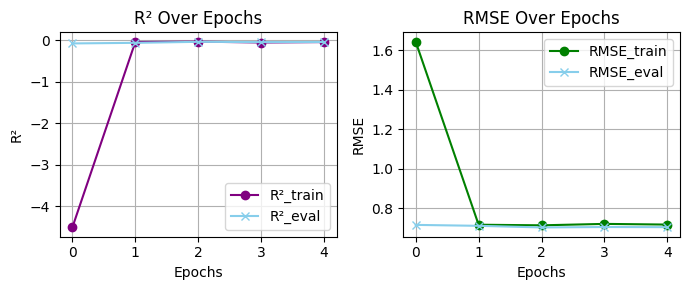

USA transfer learning model R²: -0.0114
USA transfer learning model RMSE: 0.6873


In [ ]:
class TransferModel(tf.keras.Model):
    def __init__(self, pretrained_model, new_dense_units, drop_out=0.75, name='TransferModel'):
        super(TransferModel, self).__init__(name=name)

        # Use the LSTM part from the pretrained model
        self.lstm = pretrained_model.lstm  # LSTM layer from the pretrained model
        self.lstm.trainable = False  # Freeze the LSTM layers

        # Add new dense layers
        self.dense1 = Dense(new_dense_units, activation='relu')
        self.dense2 = Dense(1, activation=None)  # Final output layer

    def call(self, inputs, training=False):
        x = self.lstm(inputs, training=training)  # Pass inputs through frozen LSTM
        x = self.dense1(x)  # Pass through new Dense layer
        output = self.dense2(x)  # Final output layer

        return output


pretrained_model.load_weights('pretrained_model.weights.h5')  # Load pretrained weights

usa_trans_model = TransferModel(pretrained_model, new_dense_units=356, drop_out=0.75)
usa_trans_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='rmse')

usa_trans_model, r2list, rmselist = train_model(usa_trans_model, dataset_usa, config, num_epochs=5)
r2list_eval, rmselist_eval = eval_model(usa_trans_model, dataset_usa, config, 5)
plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)
r2, rmse = test_model(usa_trans_model, dataset_usa, config)

print(f'USA transfer learning model R²: {r2:.4f}')
print(f'USA transfer learning model RMSE: {rmse:.4f}')

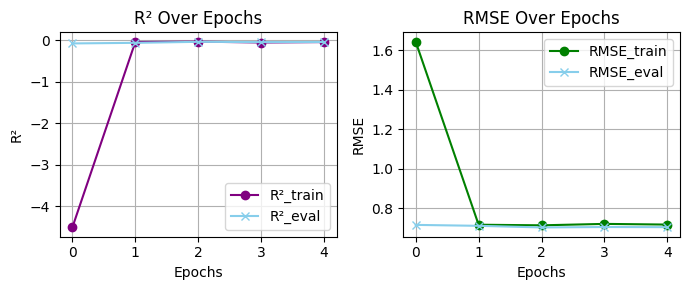

In [ ]:
# modified plot to replace to previous one

plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)

# 3. Transfer Learning on US Corn

In [ ]:
!git clone https://github.com/BigDataWUR/sample_data.git cybench/data

Cloning into 'cybench/data'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 176 (delta 1), reused 10 (delta 1), pack-reused 161 (from 1)
Receiving objects: 100% (176/176), 194.99 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (34/34), done.


In [ ]:
!git clone https://github.com/BigDataWUR/sample_data.git AgML-CY-Bench/data/sample_data

%cd AgML-CY-Bench
!pip install poetry
!poetry install

Cloning into 'AgML-CY-Bench/data/sample_data'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 176 (delta 1), reused 10 (delta 1), pack-reused 161 (from 1)
Receiving objects: 100% (176/176), 194.99 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (34/34), done.
/content/drive/MyDrive/sustainbench/AgML-CY-Bench
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.1/544.1 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.3/980.3 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.4 MB/s eta 0:00:00
   ━

Streaming output truncated to the last 5000 lines.
  - Installing nvidia-nccl-cu12 (2.19.3): Downloading... 26%
  - Installing nvidia-nvtx-cu12 (12.1.105)
  - Installing packaging (24.2)
  - Installing preshed (3.0.9)
  - Installing requests (2.32.3)
  - Installing rpds-py (0.22.3)
  - Installing six (1.17.0)
  - Installing smart-open (7.1.0)
  - Installing sympy (1.13.3): Installing...
  - Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 13%
  - Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 70%
  - Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 100%
  - Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 50%
  - Installing nvidia-nccl-cu12 (2.19.3): Downloading... 26%
  - Installing nvidia-nvtx-cu12 (12.1.105)
  - Installing packaging (24.2)
  - Installing preshed (3.0.9)
  - Installing requests (2.32.3)
  - Installing rpds-py (0.22.3)
  - Installing six (1.17.0)
  - Installing smart-open (7.1.0)
  - Installing sympy (1.13.3): Installing...
  - I

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

class LSTM_Config:
    def __init__(self, lstm_H=200, drop_out=0.75, dense=356, W=None, C=None):
        self.lstm_H = lstm_H
        self.drop_out = drop_out
        self.dense = dense
        self.W = W
        self.C = C

class LSTM_NeuralModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_Model"):
        super(LSTM_NeuralModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=self.config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - self.config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(self.config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(inputs, [batch_size, self.config.W, self.config.C // self.config.W])
        x = self.lstm(x, training=training)
        x = self.dense1(x)
        output = self.logit(x)
        return output

def find_suitable_W(C):
    divisors = [i for i in range(1, C + 1) if C % i == 0]
    for divisor in divisors:
        if 20 <= divisor <= 50:
            return divisor
    return divisors[-1]

train_data_path = '/content/drive/MyDrive/sustainbench/cybench/data/features/maize/US/grain_maize_US_train.csv'
test_data_path = '/content/drive/MyDrive/sustainbench/cybench/data/features/maize/US/grain_maize_US_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1].values

categorical_columns = X_train.select_dtypes(include=['object']).columns
numerical_columns = X_train.select_dtypes(exclude=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_numerical = X_train[numerical_columns].values
X_test_numerical = X_test[numerical_columns].values

X_train = tf.concat([tf.convert_to_tensor(X_train_encoded, dtype=tf.float32),
                     tf.convert_to_tensor(X_train_numerical, dtype=tf.float32)], axis=1)
X_test = tf.concat([tf.convert_to_tensor(X_test_encoded, dtype=tf.float32),
                    tf.convert_to_tensor(X_test_numerical, dtype=tf.float32)], axis=1)

config = LSTM_Config()
config.C = X_train.shape[1]
config.W = find_suitable_W(config.C)

X_train = tf.reshape(X_train, [-1, config.W, config.C // config.W])
X_test = tf.reshape(X_test, [-1, config.W, config.C // config.W])

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=100).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

model = LSTM_NeuralModel(config)
weights_path = '/content/drive/MyDrive/sustainbench/pretrained_model_weights.h5'

try:
    model.build(input_shape=(None, config.W, config.C // config.W))
    model.load_weights(weights_path)
except FileNotFoundError:
    pass

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')

model.fit(train_dataset, validation_data=test_dataset, epochs=10)

loss = model.evaluate(test_dataset)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'LSTM_Model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 11.2888 - val_loss: 5.9750
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 2.9076 - val_loss: 6.0334
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.8862 - val_loss: 6.4120
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.6741 - val_loss: 7.4446
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 3.3884 - val_loss: 5.4974
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.9846 - val_loss: 5.8173
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.6665 - val_loss: 5.5882
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 2.6753 - val_loss: 5.3733
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 2.7007 - val_loss: 5.6244
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 2.5809 - val_loss: 5.3617
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.7380


In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

loss = model.evaluate(test_dataset)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 2.6301 - val_loss: 5.5699
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - loss: 2.5880 - val_loss: 5.5720
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.4852 - val_loss: 5.1992
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.6864 - val_loss: 5.7078
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 2.5215 - val_loss: 5.9005
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 2.4770 - val_loss: 5.6199
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 2.5716 - val_loss: 5.8416
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 2.4597 - val_loss: 5.2483
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 2.6181 - val_loss: 6.0955
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.4877 - val_loss: 5.9216
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.5205


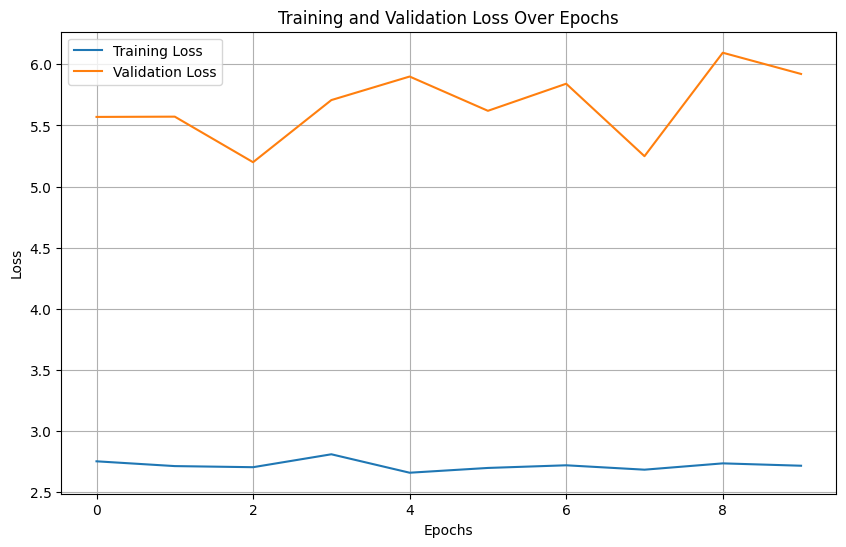

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## US Corn Training and Evaluation

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

class LSTM_Config:
    def __init__(self, lstm_H=200, drop_out=0.75, dense=356, W=None, C=None):
        self.lstm_H = lstm_H
        self.drop_out = drop_out
        self.dense = dense
        self.W = W
        self.C = C

class LSTM_NeuralModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_Model"):
        super(LSTM_NeuralModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=self.config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - self.config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(self.config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(inputs, [batch_size, self.config.W, self.config.C // self.config.W])
        x = self.lstm(x, training=training)
        x = self.dense1(x)
        output = self.logit(x)
        return output

def find_suitable_W(C):
    divisors = [i for i in range(1, C + 1) if C % i == 0]
    for divisor in divisors:
        if 20 <= divisor <= 50:
            return divisor
    return divisors[-1]

train_data_path = '/content/drive/MyDrive/sustainbench/cybench/data/features/maize/US/grain_maize_US_train.csv'
test_data_path = '/content/drive/MyDrive/sustainbench/cybench/data/features/maize/US/grain_maize_US_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1].values

categorical_columns = X_train.select_dtypes(include=['object']).columns
numerical_columns = X_train.select_dtypes(exclude=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_numerical = X_train[numerical_columns].values
X_test_numerical = X_test[numerical_columns].values

X_train = tf.concat([tf.convert_to_tensor(X_train_encoded, dtype=tf.float32),
                     tf.convert_to_tensor(X_train_numerical, dtype=tf.float32)], axis=1)
X_test = tf.concat([tf.convert_to_tensor(X_test_encoded, dtype=tf.float32),
                    tf.convert_to_tensor(X_test_numerical, dtype=tf.float32)], axis=1)

config = LSTM_Config()
config.C = X_train.shape[1]
config.W = find_suitable_W(config.C)

X_train = tf.reshape(X_train, [-1, config.W, config.C // config.W])
X_test = tf.reshape(X_test, [-1, config.W, config.C // config.W])

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=100).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

model = LSTM_NeuralModel(config)
weights_path = '/content/drive/MyDrive/sustainbench/pretrained_model_weights.h5'

try:
    model.build(input_shape=(None, config.W, config.C // config.W))
    model.load_weights(weights_path)
except FileNotFoundError:
    print("Pretrained weights not found. Proceeding without them.")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test, y_pred.flatten()))

print(f"US Corn Model R²: {r2:.4f}")
print(f"US Corn Model RMSE: {rmse:.4f}")

Pretrained weights not found. Proceeding without them.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'LSTM_Model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 11.0551 - val_loss: 9.3888
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 3.3576 - val_loss: 5.1661
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 3.0270 - val_loss: 5.2040
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 2.9018 - val_loss: 5.3755
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.8898 - val_loss: 5.2757
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 2.6039 - val_loss: 5.1914
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.6148 - val_loss: 5.1220
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 2.7068 - val_loss: 5.0508
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 2.6702 - val_loss: 5.2726
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 2.6575 - val_loss: 5.4601
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
US Corn Model R²: 0.3096
US Corn Model RMSE: 2.3378


Epoch 1: R²_train=0.4260, RMSE_train=1.6958, R²_eval=0.3292, RMSE_eval=2.3045
Epoch 2: R²_train=0.4399, RMSE_train=1.6752, R²_eval=0.3143, RMSE_eval=2.3299
Epoch 3: R²_train=0.4373, RMSE_train=1.6790, R²_eval=0.3063, RMSE_eval=2.3434
Epoch 4: R²_train=0.4471, RMSE_train=1.6644, R²_eval=0.3371, RMSE_eval=2.2909
Epoch 5: R²_train=0.4525, RMSE_train=1.6562, R²_eval=0.2972, RMSE_eval=2.3587
Epoch 6: R²_train=0.4539, RMSE_train=1.6542, R²_eval=0.2965, RMSE_eval=2.3599
Epoch 7: R²_train=0.4463, RMSE_train=1.6656, R²_eval=0.2499, RMSE_eval=2.4369
Epoch 8: R²_train=0.4561, RMSE_train=1.6508, R²_eval=0.2795, RMSE_eval=2.3883
Epoch 9: R²_train=0.4595, RMSE_train=1.6456, R²_eval=0.2787, RMSE_eval=2.3896
Epoch 10: R²_train=0.4545, RMSE_train=1.6533, R²_eval=0.2841, RMSE_eval=2.3806


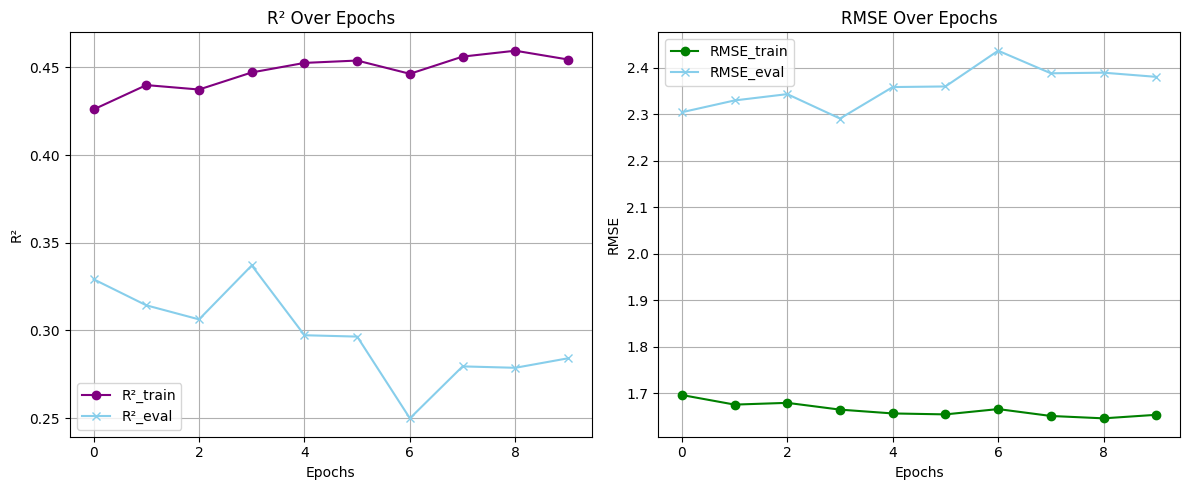

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
US Corn Model Final R²: 0.2670
US Corn Model Final RMSE: 2.4089


In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot R²
    axes[0].plot(r2list, label='R²_train', color='purple', marker='o')
    axes[0].plot(r2list_eval, label='R²_eval', color='skyblue', marker='x')
    axes[0].set_title('R² Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('R²')
    axes[0].grid(True)
    axes[0].legend()

    # Plot RMSE
    axes[1].plot(rmselist, label='RMSE_train', color='green', marker='o')
    axes[1].plot(rmselist_eval, label='RMSE_eval', color='skyblue', marker='x')
    axes[1].set_title('RMSE Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('RMSE')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(model, train_dataset, test_dataset, num_epochs=10):
    r2list, rmselist = [], []
    r2list_eval, rmselist_eval = [], []

    for epoch in range(num_epochs):
        y_true_train, y_pred_train = [], []
        for X_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(X_batch, training=True)
                loss = tf.keras.losses.MeanSquaredError()(y_batch, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            y_true_train.extend(y_batch.numpy().flatten())
            y_pred_train.extend(predictions.numpy().flatten())

        r2list.append(r2_score(y_true_train, y_pred_train))
        rmselist.append(np.sqrt(mean_squared_error(y_true_train, y_pred_train)))

        y_true_eval, y_pred_eval = [], []
        for X_batch, y_batch in test_dataset:
            predictions = model(X_batch, training=False)
            y_true_eval.extend(y_batch.numpy().flatten())
            y_pred_eval.extend(predictions.numpy().flatten())

        r2list_eval.append(r2_score(y_true_eval, y_pred_eval))
        rmselist_eval.append(np.sqrt(mean_squared_error(y_true_eval, y_pred_eval)))

        print(f"Epoch {epoch + 1}: R²_train={r2list[-1]:.4f}, RMSE_train={rmselist[-1]:.4f}, "
              f"R²_eval={r2list_eval[-1]:.4f}, RMSE_eval={rmselist_eval[-1]:.4f}")

    return r2list, rmselist, r2list_eval, rmselist_eval

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
r2list, rmselist, r2list_eval, rmselist_eval = train_and_evaluate_model(model, train_dataset, test_dataset, num_epochs=10)
plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test, y_pred.flatten()))

print(f"US Corn Model Final R²: {r2:.4f}")
print(f"US Corn Model Final RMSE: {rmse:.4f}")

## Fine-Tuning and Evaluation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test, y_pred.flatten()))

print(f"US Corn Model Final R²: {r2:.4f}")
print(f"US Corn Model Final RMSE: {rmse:.4f}")

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 2.6090 - val_loss: 6.0301
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 2.5060 - val_loss: 5.7636
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 2.4459 - val_loss: 5.9835
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 2.4273 - val_loss: 5.8504
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 2.4000 - val_loss: 5.5728
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 2.6886 - val_loss: 5.5766
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 2.4123 - val_loss: 5.5386
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 2.5266 - val_loss: 6.1396
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 2.4998 - val_loss: 5.9374
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 2.5035 - val_loss: 5.4640
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
US Corn Model Final R²: 0.3049
US Corn Model Final RMSE: 2.3457


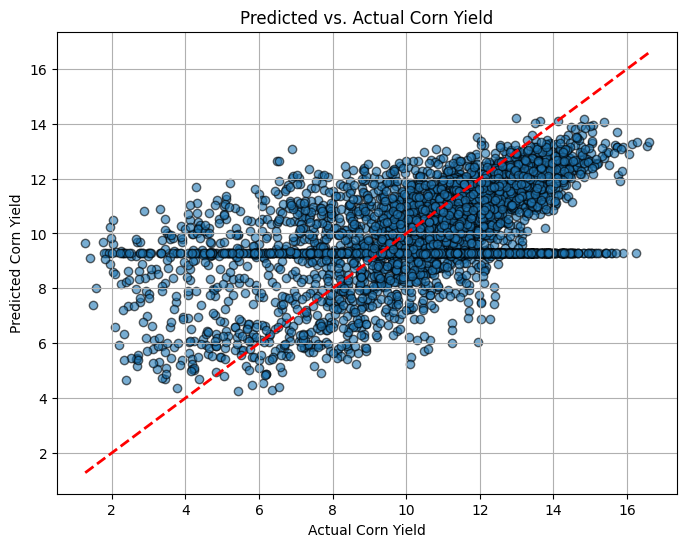

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred.flatten(), alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs. Actual Corn Yield')
plt.xlabel('Actual Corn Yield')
plt.ylabel('Predicted Corn Yield')
plt.grid(True)
plt.show()

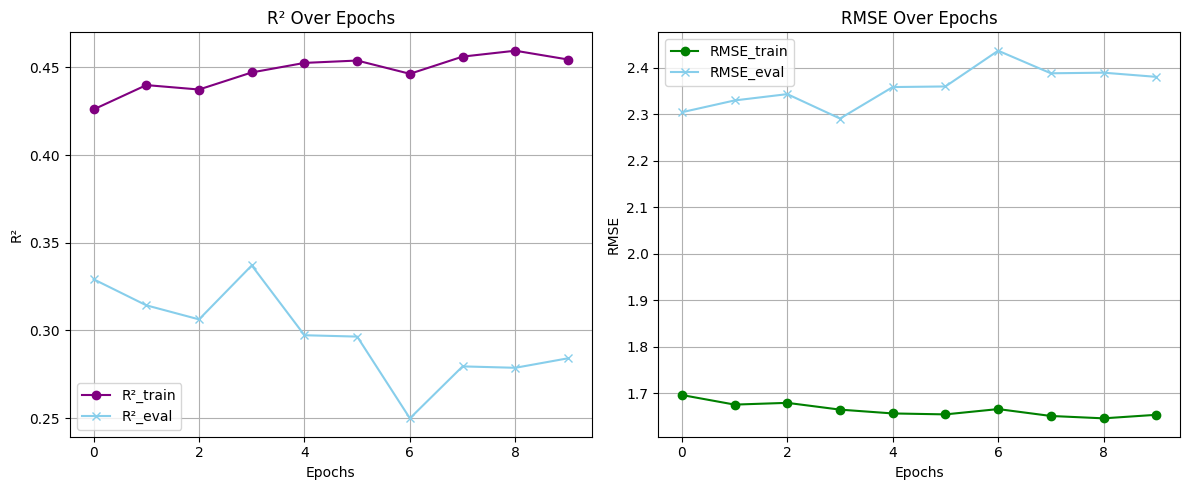

In [ ]:
plot_training_results(r2list, rmselist, r2list_eval, rmselist_eval)

## k-fold cross-validation for LSTM

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error

class LSTM_Config:
    def __init__(self, lstm_H=200, drop_out=0.75, dense=356, W=None, C=None):
        self.lstm_H = lstm_H
        self.drop_out = drop_out
        self.dense = dense
        self.W = W
        self.C = C

class LSTM_NeuralModel(tf.keras.Model):
    def __init__(self, config, name="LSTM_Model"):
        super(LSTM_NeuralModel, self).__init__(name=name)
        self.config = config
        self.lstm = tf.keras.layers.LSTM(
            units=self.config.lstm_H,
            return_sequences=False,
            return_state=False,
            dropout=1 - self.config.drop_out,
        )
        self.dense1 = tf.keras.layers.Dense(self.config.dense, activation="relu")
        self.logit = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(inputs, [batch_size, self.config.W, self.config.C // self.config.W])
        x = self.lstm(x, training=training)
        x = self.dense1(x)
        output = self.logit(x)
        return output

def calculate_dynamic_dimensions(features):
    C = features.shape[1]
    for W in range(20, 51):
        if C % W == 0:
            return W, C
    padding = W - (C % W)
    return W, C + padding

def pad_features(X, W, C):
    padding = C - X.shape[1]
    if padding > 0:
        return np.pad(X, ((0, 0), (0, padding)), mode='constant')
    return X

def k_fold_cross_validation(X, y, config, k=5, epochs=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 1
    r2_scores = []
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        config.W, config.C = calculate_dynamic_dimensions(X_train)
        X_train = pad_features(X_train, config.W, config.C)
        X_test = pad_features(X_test, config.W, config.C)

        X_train = tf.reshape(X_train, [-1, config.W, config.C // config.W])
        X_test = tf.reshape(X_test, [-1, config.W, config.C // config.W])

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(32).prefetch(tf.data.AUTOTUNE)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

        model = LSTM_NeuralModel(config)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

        model.fit(train_dataset, epochs=epochs, verbose=1)

        y_pred = model.predict(X_test)
        fold_r2 = r2_score(y_test, y_pred.flatten())
        fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred.flatten()))

        r2_scores.append(fold_r2)
        rmse_scores.append(fold_rmse)
        fold += 1

    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)
    return r2_scores, rmse_scores, avg_r2, avg_rmse

X = np.concatenate([X_train_encoded, X_train_numerical], axis=1)
y = y_train

config = LSTM_Config()
k = 5
epochs = 10
r2_scores, rmse_scores, avg_r2, avg_rmse = k_fold_cross_validation(X, y, config, k=k, epochs=epochs)

print(f"Fold-wise R² Scores: {r2_scores}")
print(f"Fold-wise RMSE Scores: {rmse_scores}")
print(f"Overall Average R²: {avg_r2:.4f}")
print(f"Overall Average RMSE: {avg_rmse:.4f}")


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 13.2204
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4248
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.7675
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5198
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3405
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3205
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2196
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1629
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0866
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0665
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 14.3506
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.2332
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6990
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5083
Epoch 5/10
180/180 ━

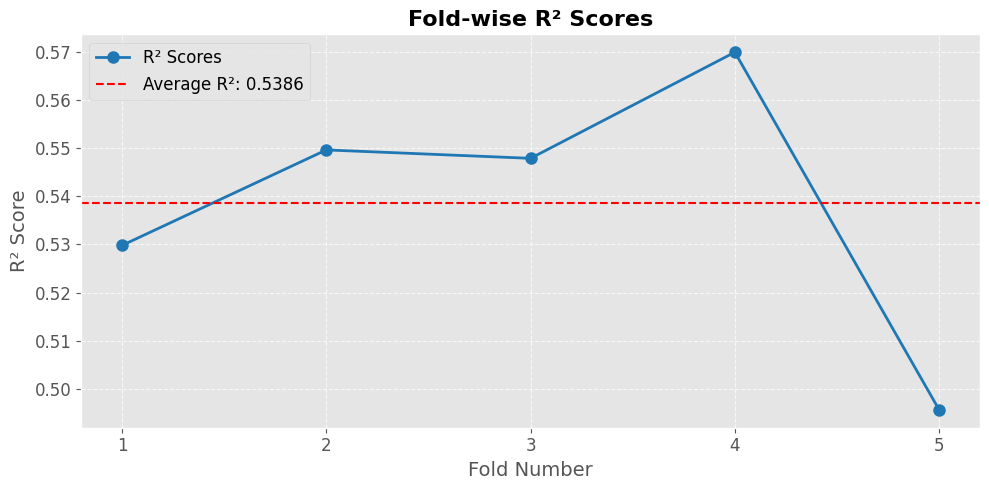

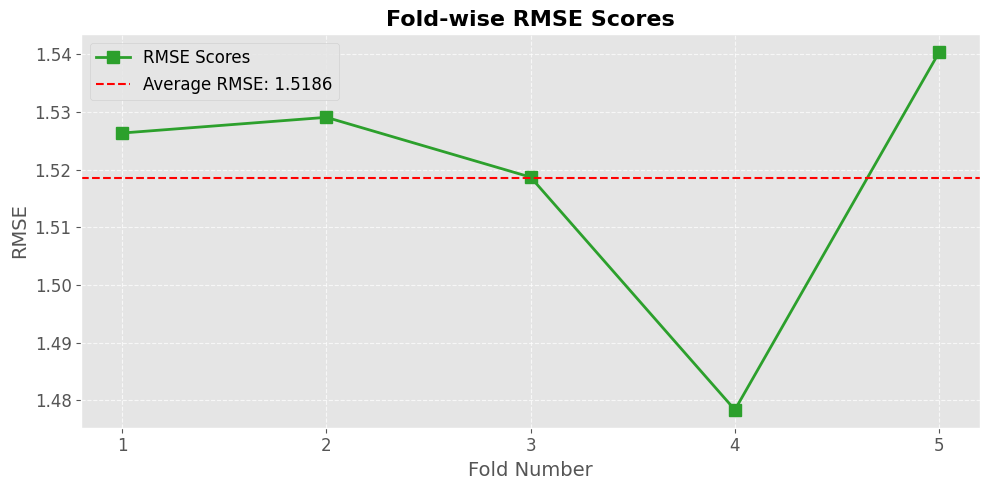

In [ ]:
import matplotlib.pyplot as plt

#R²
plt.figure(figsize=(10, 5))
plt.plot(folds, r2_scores, marker='o', color='#1f77b4', label='R² Scores', linewidth=2, markersize=8)
plt.axhline(y=avg_r2, color='red', linestyle='--', linewidth=1.5, label=f'Average R²: {avg_r2:.4f}')
plt.title('Fold-wise R² Scores', fontsize=16, weight='bold')
plt.xlabel('Fold Number', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.xticks(folds, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#RMSE
plt.figure(figsize=(10, 5))
plt.plot(folds, rmse_scores, marker='s', color='#2ca02c', label='RMSE Scores', linewidth=2, markersize=8)
plt.axhline(y=avg_rmse, color='red', linestyle='--', linewidth=1.5, label=f'Average RMSE: {avg_rmse:.4f}')
plt.title('Fold-wise RMSE Scores', fontsize=16, weight='bold')
plt.xlabel('Fold Number', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xticks(folds, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# 4. Adding new fearture to improve the Argentina lstm model